<a href="https://colab.research.google.com/github/chitra-psg/telecom_churn/blob/main/telecom_churn_prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn Prediction

**Author:** Chitra Govindasamy, Mohan Sharma

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [ ]:
#Data Structures
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import os
from datetime import datetime as dt

#sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler ,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score ,confusion_matrix, precision_score, recall_score ,classification_report,accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV ,RepeatedStratifiedKFold ,cross_val_score ,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import f1_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Common Functions

In [ ]:
## Common Function to plot the countplot
def PlotAttribute(df_data, attribute, title, xlabel, ylabel, hueattribute = None, order = None):
  if ( hueattribute ):
    chrt = sns.countplot(x=attribute,hue=hueattribute, data=df_data, order=order)
  else:
    chrt = sns.countplot(x=attribute,data=df_data)
  chrt.set_title(title,fontsize=14)
  chrt.set_xlabel(xlabel,fontsize=14)
  chrt.set_ylabel(ylabel,fontsize=14)

  # To show count of values above bars
  for patch in chrt.patches:
      x, y = patch.get_xy()   # Bottom-left corner.
      x += patch.get_width()/2 # Middle of the width.
      y += patch.get_height()  # Top of the bar
      color = patch.get_facecolor()
      chrt.text(x, y, str(y))
  return chrt

In [ ]:
#2 decimal places
pd.options.display.float_format = '{:.2f}'.format
# The dataset has many columns and the list is getting truncated in the output. Hence, adjusting the configuration
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('mode.use_inf_as_na', True)
#chart style
sns.set_style('darkgrid')

In [ ]:
def plot(hyperparameters,scores):
     # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters].data, scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_"+hyperparameters].data, scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
# Uses Random Forest pipeline , purpose to hyper parameter tuning of the model
def rf_model(params,pipe,X_train,y_train):
    folds = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    model = GridSearchCV(estimator=pipe, cv=folds, param_grid=params, scoring='accuracy', n_jobs=-1, verbose=1,return_train_score=True)
    model.fit(X_train,y_train)
    return model.cv_results_


In [ ]:
## Common Function to plot the countplot
def PlotAttribute(df_data, attribute, title, xlabel, ylabel, hueattribute = None, order = None):
  if ( hueattribute ):
    chrt = sns.countplot(x=attribute,hue=hueattribute, data=df_data, order=order)
  else:
    chrt = sns.countplot(x=attribute,data=df_data)
  chrt.set_title(title,fontsize=14)
  chrt.set_xlabel(xlabel,fontsize=14)
  chrt.set_ylabel(ylabel,fontsize=14)

  # To show count of values above bars
  for patch in chrt.patches:
      x, y = patch.get_xy()   # Bottom-left corner.
      x += patch.get_width()/2 # Middle of the width.
      y += patch.get_height()  # Top of the bar
      color = patch.get_facecolor()
      chrt.text(x, y, str(y))
  return chrt

In [ ]:
# Handle outlier using k-sigmoid method (Reference : starter notebook)
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [ ]:
# Common Function to process data
def Preprocess(df_data, action):

  if ( action == 'DropUniqueColumns' ):
    df_data.drop(['id'], axis=1, inplace=True)

  elif(action == 'Drop0VariationColumns'):
    df_data.drop(['circle_id',
                  'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',\
                  'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
                  'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8',
                   'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8'], axis=1, inplace=True)

  elif(action == 'DeriveLastRechargeDay'):
    CURRENT_DAY = (dt.strptime('2014/9/01', "%Y/%m/%d")) #assuming we are in the begining of Sep trying to predict churn so that necessary actions can be taken to prevent churn
    df_data['lastrechargedayago'] = abs(((df_data[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max(axis=1) ) - CURRENT_DAY).dt.days)
    df_data.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], axis = 1, inplace = True)
    df_data['lastdatarechargedayago'] = abs(((df_data[['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']].max(axis=1) ) - CURRENT_DAY).dt.days)
    df_data.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], axis = 1, inplace = True)

  elif(action == 'Fill0inFloatColumns'):
    for col in df_data.select_dtypes(include="float64").columns:
        df_data[col].fillna(0, inplace=True)

  elif(action == 'ConverttoDate'):
      # Convert date columns to date format
      for col in df_data.select_dtypes(include="object").columns:
          df_data[col] =  pd.to_datetime(df_data[col], format='%m/%d/%Y')

  elif(action == 'HandleOutlier'):
      df_data = df_data.apply(cap_outliers, axis=0)

  elif(action == 'DeriveAdditionalFeatures'):
    df_data['loc_og_mou_growth']  = round( (df_data['loc_og_mou_8']  /  (df_data[['loc_og_mou_6', 'loc_og_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['std_og_mou_growth']  = round( (df_data['std_og_mou_8']  /  (df_data[['std_og_mou_6', 'std_og_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['isd_og_mou_growth']  = round( (df_data['isd_og_mou_8']  /  (df_data[['isd_og_mou_6', 'isd_og_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['spl_og_mou_growth']  = round( (df_data['spl_og_mou_8']  /  (df_data[['spl_og_mou_6', 'spl_og_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    #df_data['total_og_mou_growth']  = round( (df_data['total_og_mou_8']  /  (df_data[['total_og_mou_6', 'total_og_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)

    df_data['loc_ic_mou_growth']  = round( (df_data['loc_ic_mou_8']  /  (df_data[['loc_ic_mou_6', 'loc_ic_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['std_ic_mou_growth']  = round( (df_data['std_ic_mou_8']  /  (df_data[['std_ic_mou_6', 'std_ic_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['isd_ic_mou_growth']  = round( (df_data['isd_ic_mou_8']  /  (df_data[['isd_ic_mou_6', 'isd_ic_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['spl_ic_mou_growth']  = round( (df_data['spl_ic_mou_8']  /  (df_data[['spl_ic_mou_6', 'spl_ic_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    #df_data['total_ic_mou_growth']  = round( (df_data['total_ic_mou_8']  /  (df_data[['total_ic_mou_6', 'total_ic_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)

    df_data['total_rech_amt_growth']  = round( (df_data['total_rech_amt_8']  /  (df_data[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['av_rech_amt_data_growth']  = round( (df_data['av_rech_amt_data_8']  /  (df_data[['av_rech_amt_data_6', 'av_rech_amt_data_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['max_rech_amt_growth']  = round( (df_data['max_rech_amt_8']  /  (df_data[['max_rech_amt_6', 'max_rech_amt_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)

    df_data['vol_2g_mb_growth']  = round( (df_data['vol_2g_mb_8']  /  (df_data[['vol_2g_mb_6', 'vol_2g_mb_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['vol_3g_mb_growth']  = round( (df_data['vol_3g_mb_8']  /  (df_data[['vol_3g_mb_6', 'vol_3g_mb_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)

    df_data['onnet_mou_growth']  = round( (df_data['onnet_mou_8']  /  (df_data[['onnet_mou_6', 'onnet_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['offnet_mou_growth']  = round( (df_data['offnet_mou_8']  /  (df_data[['offnet_mou_6', 'offnet_mou_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)

    df_data['arpu_3g_growth']  = round( (df_data['arpu_3g_8']  /  (df_data[['arpu_3g_6', 'arpu_3g_8']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['arpu_2g_growth']  = round( (df_data['arpu_2g_8']  /  (df_data[['arpu_2g_6', 'arpu_2g_8']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)
    df_data['arpu_growth']  = round( (df_data['arpu_8']  /  (df_data[['arpu_6', 'arpu_7']].mean(axis=1) )  ), 1).replace([np.inf, -np.inf], 1)

  elif(action == 'DropRedundantColumns'):
    df_data.drop(['vol_2g_mb_6', 'vol_3g_mb_6', 'vol_2g_mb_7', 'vol_3g_mb_7',
                  'vol_2g_mb_8', 'vol_3g_mb_8', 'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8',
                  'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8',
                  'max_rech_amt_6','max_rech_amt_7','max_rech_amt_8'], axis = 1, inplace = True)

    df_data.drop(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
                  'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], axis = 1, inplace = True)

    #loc_og_mou_* = loc_og_t2t_mou_*  + loc_og_t2m_mou_*   + loc_og_t2f_mou_* 	     + loc_og_t2c_mou_*
    df_data.drop(['loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6',
                  'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7',
                  'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8'], axis = 1, inplace = True)

     # std_og_mou_* = std_og_t2t_mou_*  + std_og_t2m_mou_*   + std_og_t2f_mou_* 	     + std_og_t2c_mou_*
    df_data.drop(['std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6',
                  'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7',
                  'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8'], axis = 1, inplace = True)

    # loc_ic_mou_* = loc_ic_t2t_mou_*  + loc_ic_t2m_mou_*   + loc_ic_t2f_mou_* 	     + loc_ic_t2c_mou_*
    df_data.drop(['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6',
                  'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7',
                  'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8'], axis = 1, inplace = True)

     # std_ic_mou_* = std_ic_t2t_mou_*  + std_ic_t2m_mou_*   + std_ic_t2f_mou_* 	     + std_ic_t2c_mou_*
    df_data.drop(['std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6',
                  'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7',
                  'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8'], axis = 1, inplace = True)

    # total_og_mou_* = loc_og_mou_* + std_og_mou_* + isd_og_mou_* + spl_og_mou_* + <x> component
    df_data.drop(['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8',
                  'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
                  'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
                  'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8',
                  'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8'
                  ], axis = 1, inplace = True)

    # total_ic_mou_* = loc_ic_mou_* + std_ic_mou_* + spl_ic_mou_* + isd_ic_mou_* + <y> component
    df_data.drop(['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8',
                  'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8',
                  'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8',
                  'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8',
                  'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8'], axis = 1, inplace = True)

    df_data.drop(['arpu_6', 'arpu_7', 'arpu_8',
                  'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
                  'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8'], axis = 1, inplace = True)

  return df_data

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables.

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [ ]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


# 2. Data Preparation

In [ ]:
data.head().T

,0,1,2,3,4
id,0,1,2,3,4
circle_id,109,109,109,109,109
loc_og_t2o_mou,0.00,0.00,0.00,0.00,0.00
std_og_t2o_mou,0.00,0.00,0.00,0.00,0.00
loc_ic_t2o_mou,0.00,0.00,0.00,0.00,0.00
last_date_of_month_6,6/30/2014,6/30/2014,6/30/2014,6/30/2014,6/30/2014
last_date_of_month_7,7/31/2014,7/31/2014,7/31/2014,7/31/2014,7/31/2014
last_date_of_month_8,8/31/2014,8/31/2014,8/31/2014,8/31/2014,8/31/2014
arpu_6,31.28,0.00,60.81,156.36,240.71
arpu_7,87.01,122.79,103.18,205.26,128.19


Let's look at each variable's datatype:

In [ ]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

Note: Most of the fields are numeric and few date fields are object type which needs to be converted to date

In [ ]:
data.describe(include="all")

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.00,69999.00,69297.00,69297.00,69297.00,69999,69600,69266,69999.00,69999.00,69999.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,69999.00,69999.00,69999.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,69999.00,69999.00,69999.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,68898,68765,67538,69999.00,69999.00,69999.00,17568,17865,18417,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,6

Note:
1. There are fields like ID, circle ID which may not requried for further analysis. as ID is unique row ID and circle ID has zero variation.
2. There are outliers in the data
3. There are few fields like night_pack, fb_user which have 0 or 1 (and null) which implies is a categorical field.

In [ ]:
# Get the unique count
for col in data.columns:
    print("No of rows in " + col + ": ", len(data[col].unique()))

No of rows in id:  69999
No of rows in circle_id:  1
No of rows in loc_og_t2o_mou:  2
No of rows in std_og_t2o_mou:  2
No of rows in loc_ic_t2o_mou:  2
No of rows in last_date_of_month_6:  1
No of rows in last_date_of_month_7:  2
No of rows in last_date_of_month_8:  2
No of rows in arpu_6:  61615
No of rows in arpu_7:  61425
No of rows in arpu_8:  60194
No of rows in onnet_mou_6:  20058
No of rows in onnet_mou_7:  20077
No of rows in onnet_mou_8:  19726
No of rows in offnet_mou_6:  26255
No of rows in offnet_mou_7:  26140
No of rows in offnet_mou_8:  25996
No of rows in roam_ic_mou_6:  5307
No of rows in roam_ic_mou_7:  4241
No of rows in roam_ic_mou_8:  4253
No of rows in roam_og_mou_6:  6569
No of rows in roam_og_mou_7:  5306
No of rows in roam_og_mou_8:  5216
No of rows in loc_og_t2t_mou_6:  11492
No of rows in loc_og_t2t_mou_7:  11360
No of rows in loc_og_t2t_mou_8:  11297
No of rows in loc_og_t2m_mou_6:  17849
No of rows in loc_og_t2m_mou_7:  17642
No of rows in loc_og_t2m_mou_8: 

We can observe from the above result that, the following fields have few values which may not be useful for analysis

id

=> ***Unique value ***

circle_id ; last_date_of_month_6; last_date_of_month_7; last_date_of_month_8

=> ***same values across all rows***;

loc_og_t2o_mou; std_og_t2o_mou; loc_ic_t2o_mou
std_og_t2c_mou_6; std_og_t2c_mou_7; std_og_t2c_mou_8
std_ic_t2o_mou_6; std_ic_t2o_mou_7; std_ic_t2o_mou_8

=>*** Only 0 or NULL value in these columns***


In [ ]:
distinct_value = data.nunique()
distinct_value

id                          69999
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
arpu_6                      61615
arpu_7                      61425
arpu_8                      60194
onnet_mou_6                 20057
onnet_mou_7                 20076
onnet_mou_8                 19725
offnet_mou_6                26254
offnet_mou_7                26139
offnet_mou_8                25995
roam_ic_mou_6                5306
roam_ic_mou_7                4240
roam_ic_mou_8                4252
roam_og_mou_6                6568
roam_og_mou_7                5305
roam_og_mou_8                5215
loc_og_t2t_mou_6            11491
loc_og_t2t_mou_7            11359
loc_og_t2t_mou_8            11296
loc_og_t2m_mou_6            17848
loc_og_t2m_mou_7            17641
loc_og_t2m_mou_8            17616
loc_og_t2f_mou

Check % of NULLs in each column

In [ ]:
(data.isnull().sum()/ len(data)) * 100

id                          0.00
circle_id                   0.00
loc_og_t2o_mou              1.00
std_og_t2o_mou              1.00
loc_ic_t2o_mou              1.00
last_date_of_month_6        0.00
last_date_of_month_7        0.57
last_date_of_month_8        1.05
arpu_6                      0.00
arpu_7                      0.00
arpu_8                      0.00
onnet_mou_6                 3.95
onnet_mou_7                 3.84
onnet_mou_8                 5.29
offnet_mou_6                3.95
offnet_mou_7                3.84
offnet_mou_8                5.29
roam_ic_mou_6               3.95
roam_ic_mou_7               3.84
roam_ic_mou_8               5.29
roam_og_mou_6               3.95
roam_og_mou_7               3.84
roam_og_mou_8               5.29
loc_og_t2t_mou_6            3.95
loc_og_t2t_mou_7            3.84
loc_og_t2t_mou_8            5.29
loc_og_t2m_mou_6            3.95
loc_og_t2m_mou_7            3.84
loc_og_t2m_mou_8            5.29
loc_og_t2f_mou_6            3.95
loc_og_t2f

Few columns have more than 70% missing values. The missing values % for month 6,7,8 across various fields here and it looks like the customers didnt recharge that particualr month and hence the metrics related to that month is also null.

The list columns can be grouped as arpu, mou, ic, og, rech, 3g mb, 2g mb, service flag fields like - night pack, monthly 2g,3g, sachet, fb service. In places where there is null it means the facility was not used e.g. mou null indicate no call was made so these can be filled with 0. Flag fields like fb service being null indicate that the service wasnt used and that be 0 as well.

As per the problem statement is focussed on high value customers churn probability. A customer whose recharge amount is at higher end ( e.g. more than average recharge amount) will be considered high value customers. So, lets keep the rech related columns for now and impute missing values.

In [ ]:
outlier = data.describe().T.round(2)
outlier['flag'] =  (outlier['75%'] != 0) | (((outlier['max'] - outlier['75%']) / (outlier['75%'] - outlier['50%'])) > 50)
outlier

,count,mean,std,min,25%,50%,75%,max,flag
id,69999.00,34999.00,20207.12,0.00,17499.50,34999.00,52498.50,69998.00,True
circle_id,69999.00,109.00,0.00,109.00,109.00,109.00,109.00,109.00,True
loc_og_t2o_mou,69297.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
std_og_t2o_mou,69297.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
loc_ic_t2o_mou,69297.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
arpu_6,69999.00,283.13,334.21,-2258.71,93.58,197.48,370.79,27731.09,True
arpu_7,69999.00,278.19,344.37,-1289.71,86.71,191.59,365.37,35145.83,True
arpu_8,69999.00,278.86,351.92,-945.81,84.10,192.23,369.91,33543.62,True
onnet_mou_6,67231.00,133.15,299.96,0.00,7.41,34.11,119.39,7376.71,True
onnet_mou_7,67312.00,133.89,311.28,0.00,6.68,32.28,115.84,8157.78,True


###Note : Most of the attributes have outlier in it. We could treat the outliers by removing the records are handle them via. scaling technique (Robust Scaler)

#3. Preprocessing

In [ ]:
data = Preprocess(data,'DropUniqueColumns')
data = Preprocess(data,'Drop0VariationColumns')
data = Preprocess(data,'ConverttoDate')
data = Preprocess(data,'DeriveLastRechargeDay')
data = Preprocess(data,'Fill0inFloatColumns')
data = Preprocess(data,'DeriveAdditionalFeatures')
#data = Preprocess(data,'DropRedundantColumns')
data = Preprocess(data,'HandleOutliers')


In [ ]:
(data.isnull().sum()/ len(data)) * 100

arpu_6                    0.00
arpu_7                    0.00
arpu_8                    0.00
onnet_mou_6               0.00
onnet_mou_7               0.00
onnet_mou_8               0.00
offnet_mou_6              0.00
offnet_mou_7              0.00
offnet_mou_8              0.00
roam_ic_mou_6             0.00
roam_ic_mou_7             0.00
roam_ic_mou_8             0.00
roam_og_mou_6             0.00
roam_og_mou_7             0.00
roam_og_mou_8             0.00
loc_og_t2t_mou_6          0.00
loc_og_t2t_mou_7          0.00
loc_og_t2t_mou_8          0.00
loc_og_t2m_mou_6          0.00
loc_og_t2m_mou_7          0.00
loc_og_t2m_mou_8          0.00
loc_og_t2f_mou_6          0.00
loc_og_t2f_mou_7          0.00
loc_og_t2f_mou_8          0.00
loc_og_t2c_mou_6          0.00
loc_og_t2c_mou_7          0.00
loc_og_t2c_mou_8          0.00
loc_og_mou_6              0.00
loc_og_mou_7              0.00
loc_og_mou_8              0.00
std_og_t2t_mou_6          0.00
std_og_t2t_mou_7          0.00
std_og_t

### Filter for High Value Customer

Identify High Value Customer based on arpu - Average revenue per user measures the amount of money that a company can expect to generate from an individual customer. June /Julyis expected to be in good phase where arpu is assumed to be good. We will use June/July arpu to filter customers. Each month, 50% of revenue is generated by 20% customers whose arpu is above 80th percentile. We will use this logic to filter high value customers

In [ ]:
df6 = data.loc[(data['arpu_6'] >= data['arpu_6'].quantile(0.8))]
df7 = data.loc[(data['arpu_7'] >= data['arpu_7'].quantile(0.8))]

data_key_customers = pd.concat([df6,df7]).drop_duplicates().reset_index(drop=True)
print('% of revenue generated by the filtered customers for June = ', df6['arpu_6'].sum()/data['arpu_6'].sum() )
print('% of revenue generated by the filtered customers for July = ', df7['arpu_7'].sum()/data['arpu_7'].sum() )


% of revenue generated by the filtered customers for June =  0.5249726111888899
% of revenue generated by the filtered customers for July =  0.5317645851838823


In [ ]:
data_key_customers.shape

(18792, 172)

# 4. EDA

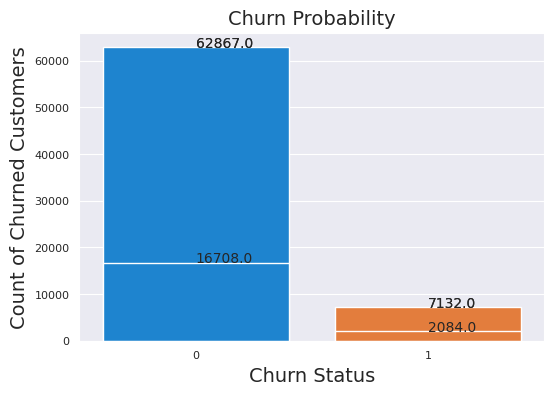

In [ ]:
#Analysis on Churn Probability
plt.figure(figsize= (6,4))
PlotAttribute(data, 'churn_probability', 'Churn Probability', 'Churn Status', 'Count of Churned Customers')
PlotAttribute(data_key_customers, 'churn_probability', 'Churn Probability', 'Churn Status', 'Count of Churned Customers')
plt.show()



Note:

Overall, 10% customers have churned.

Among the total high value customers, 12 % customers have churned.

Approx. Among total customers who have churned, 30% customers are high value customers

### Last Recharge Date

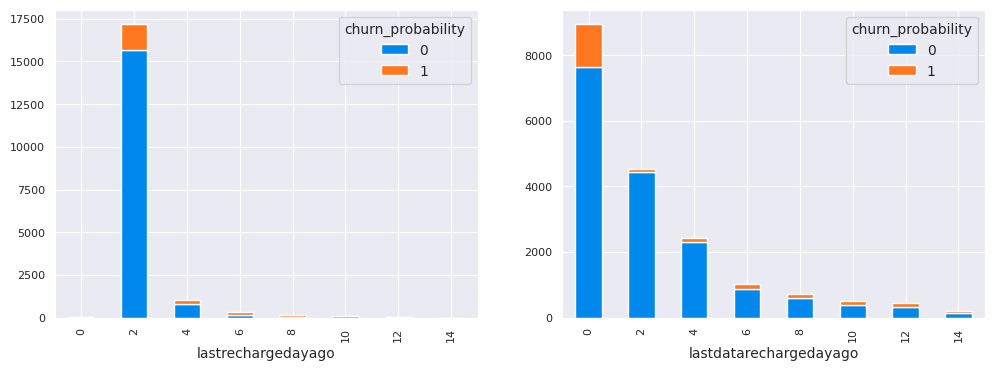

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
# bin the aon column with yearwise segments and plot the counts for each segments
bins = [-1, 0, 2, 4, 6,8, 10, 12, 14]
labels = [0, 2, 4, 6,8, 10, 12, 14]
pd.crosstab(pd.cut(round((data_key_customers['lastrechargedayago']/7),1), bins = bins, labels = labels ), data_key_customers['churn_probability']).plot(kind='bar', stacked=True,  ax = ax1)
pd.crosstab(pd.cut(round((data_key_customers['lastdatarechargedayago']/7),1), bins = bins, labels = labels ), data_key_customers['churn_probability']).plot(kind='bar', stacked=True,  ax = ax2)
plt.show()

Note :

Even customers who have recharged in the last 2 weeks have churned.

Last Data Recharge being 0 indicates the date is not available. We can see customers who havent recharged data in the recent past/unknown have churned more

### Age on Network

<Figure size 600x400 with 0 Axes>

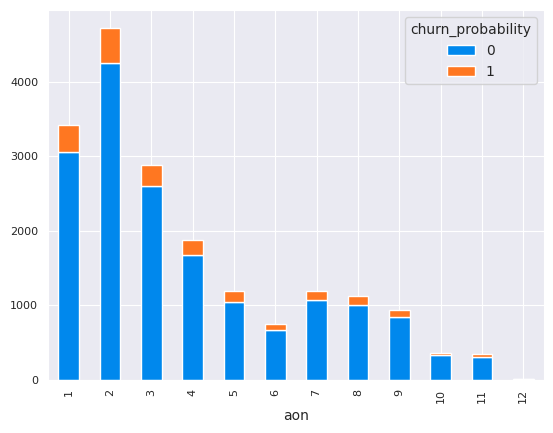

In [ ]:
plt.figure(figsize= (6,4))
# bin the aon column with yearwise segments and plot the counts for each segments
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#sns.countplot(pd.cut(round(((data['aon']/30)/12),1), bins = bins, labels = labels ), ax =ax1)
pd.crosstab(pd.cut(round(((data_key_customers['aon']/30)/12),1), bins = bins, labels = labels ), data['churn_probability']).plot(kind='bar', stacked=True)
plt.show()
#Churn probability is higher when aon is between 1 and 3 years.

### Average revenue per user

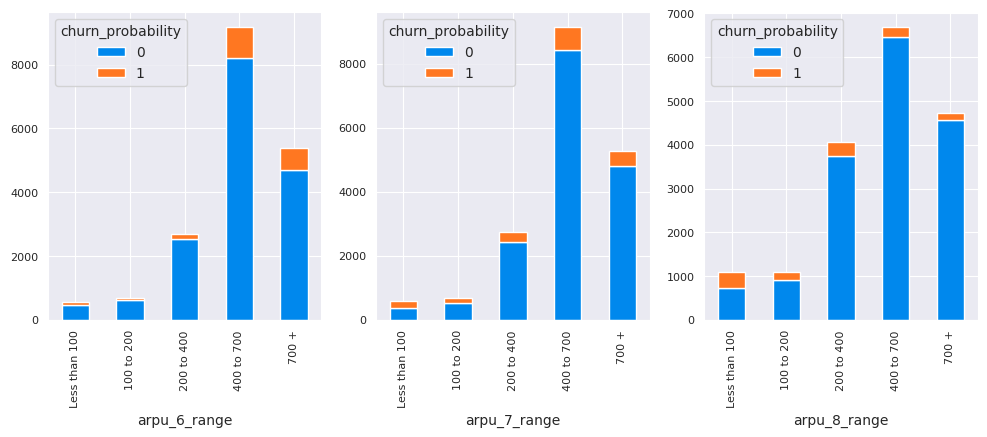

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 4))
arpu_bins = [0, 100,200,400,700,15000]
arpu_bucket = ['Less than 100', '100 to 200', '200 to 400', '400 to 700', '700 +']
data_key_customers['arpu_6_range'] = pd.cut(data_key_customers['arpu_6'].astype(int), arpu_bins, labels=arpu_bucket)
data_key_customers['arpu_7_range'] = pd.cut(data_key_customers['arpu_7'].astype(int), arpu_bins, labels=arpu_bucket)
data_key_customers['arpu_8_range'] = pd.cut(data_key_customers['arpu_8'].astype(int), arpu_bins, labels=arpu_bucket)
#print(data['arpu_6_range'].value_counts(), "\n" ,
#data['arpu_7_range'].value_counts() , "\n",
#data['arpu_8_range'].value_counts())
pd.crosstab( data_key_customers['arpu_6_range'], data_key_customers['churn_probability']).plot(kind='bar', stacked=True, ax = ax1)

pd.crosstab( data_key_customers['arpu_7_range'], data_key_customers['churn_probability']).plot(kind='bar', stacked=True, ax = ax2)

pd.crosstab( data_key_customers['arpu_8_range'], data_key_customers['churn_probability']).plot(kind='bar', stacked=True, ax = ax3)


data_key_customers.drop(['arpu_6_range', 'arpu_7_range', 'arpu_8_range'], axis = 1, inplace = True)

# It can be noticed that arpu reduces over the period when the customer is about to churn

In [ ]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={'total_ic_mou_6':np.sum,'total_ic_mou_7':np.sum,'total_ic_mou_8':np.sum,
                                                                   'total_og_mou_6':np.sum,'total_og_mou_7':np.sum,'total_og_mou_8':np.sum}))).round(2)
table

,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn_probability,,,,,,
0,"5,220,803.68","5,452,243.98","5,299,921.48","11,886,647.38","12,650,548.15","11,755,970.96"
1,"476,655.5","335,039.46","117,299.0","1,720,832.85","1,235,183.23","421,028.34"


Note: In the action phase, there is decline in both incoming and outgoing minutes

In [ ]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={ 'total_rech_amt_6':np.sum,'total_rech_amt_7':np.sum,'total_rech_amt_8':np.sum,
                                                                   'last_day_rch_amt_6':np.sum,'last_day_rch_amt_7':np.sum,'last_day_rch_amt_8':np.sum}))).round(2)
table

,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
churn_probability,,,,,,
0,1763098,1765780,1720468,11961929,12231309,11439625
1,202732,141054,62077,1581862,1128752,463166


Note: We can see recharge amount going down from July itself in case of churn customers.

In [ ]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={'arpu_6':np.sum,'arpu_7':np.sum,'arpu_8':np.sum,
                                                                   'arpu_3g_6':np.sum,'arpu_3g_7':np.sum,'arpu_3g_8':np.sum,
                                                                   'arpu_2g_6':np.sum,'arpu_2g_7':np.sum,'arpu_2g_8':np.sum}))).round(2)
table

,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_6,arpu_7,arpu_8
churn_probability,,,,,,,,,
0,"930,783.16","988,717.56","920,991.64","1,011,660.82","1,071,999.28","1,010,151.37","10,238,657.72","10,502,555.31","9,851,675.15"
1,"89,226.4","68,282.36","24,275.48","97,769.48","68,903.93","25,369.78","1,372,525.36","1,008,051.32","433,936.29"


Note : In cases of churn, we can notice arpu declining over the period. Arpu is a good indicator to identify customer who might churn soon.

In [ ]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={'total_og_mou_6':np.sum,'total_og_mou_7':np.sum,'total_og_mou_8':np.sum,
                                                                   'total_ic_mou_6':np.sum,'total_ic_mou_7':np.sum,'total_ic_mou_8':np.sum}))).round(2)
table

,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn_probability,,,,,,
0,"5,220,803.68","5,452,243.98","5,299,921.48","11,886,647.38","12,650,548.15","11,755,970.96"
1,"476,655.5","335,039.46","117,299.0","1,720,832.85","1,235,183.23","421,028.34"


Note : Outgoing calls, Incoming Calls and recharge amount for data seems to be declining for during the action phase in cases of customer churning

In [ ]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={'loc_og_mou_6':np.sum,'loc_og_mou_7':np.sum,'loc_og_mou_8':np.sum,
                                                                   'loc_ic_mou_6':np.sum,'loc_ic_mou_7':np.sum,'loc_ic_mou_8':np.sum}))).round(2)
table


,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8
churn_probability,,,,,,
0,"4,173,804.47","4,301,480.87","4,206,235.67","5,001,202.58","5,076,909.01","4,777,359.57"
1,"329,338.97","229,251.47","82,111.23","363,803.1","249,815.71","88,439.94"


Note : Significant decline in local incoming and outgoing calls noticed during action phase

In [ ]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={'total_ic_mou_6':np.sum,'total_ic_mou_7':np.sum,'total_ic_mou_8':np.sum,
                                                                   'total_og_mou_6':np.sum,'total_og_mou_7':np.sum,'total_og_mou_8':np.sum}))).round(2)
table

,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn_probability,,,,,,
0,"5,220,803.68","5,452,243.98","5,299,921.48","11,886,647.38","12,650,548.15","11,755,970.96"
1,"476,655.5","335,039.46","117,299.0","1,720,832.85","1,235,183.23","421,028.34"


Note : Significant decline in total incoming and outgoing calls as well noticed during action phase

In [ ]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={
                                                                   'total_rech_amt_6':np.sum,'total_rech_amt_7':np.sum,'total_rech_amt_8':np.sum,
                                                                   'max_rech_amt_6':np.sum,'max_rech_amt_7':np.sum,'max_rech_amt_8':np.sum}))).round(2)
table

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
churn_probability,,,,,,
0,2877177,2943728,2918129,11961929,12231309,11439625
1,336371,276362,155746,1581862,1128752,463166


Note : Decline in total recharge amount and max. reach amount noticed during action phase

In [ ]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={
                                                                   'av_rech_amt_data_6':np.sum,'av_rech_amt_data_7':np.sum,'av_rech_amt_data_8':np.sum}))).round(2)
table


,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
churn_probability,,,
0,"1,635,437.89","1,792,896.64","1,667,146.31"
1,"135,116.0","109,712.58","40,395.33"


Note : Significant decline in average amount recharged for data noticed during action phase

### Categorical Fields - Service packs

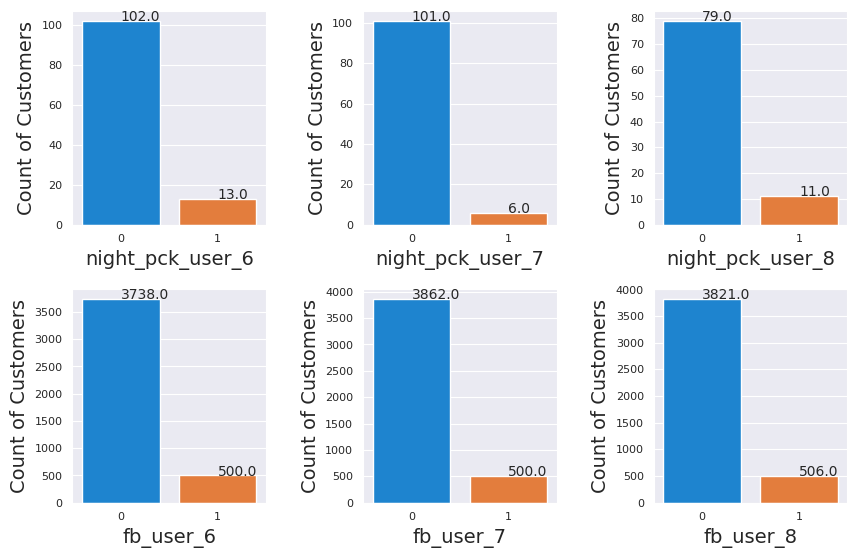

In [ ]:
#Analysis on categorrical fields
category_list = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']
counter = 1

plt.figure(figsize = (10, 10))

for col_list in category_list:
    plt.subplot(3, 3, counter)
    service_data = data_key_customers.loc[(data[col_list] == 1)]
    PlotAttribute(service_data, 'churn_probability', '', col_list, 'Count of Customers')
    counter += 1

plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.5)
plt.show()

Note : There doesnt seem to be much variation in night pack /3g sachet but there is slight reduction in Facebook service usage among churn customers

In [ ]:
pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sweetviz as sv
sweet_report = sv.analyze(data_key_customers, pairwise_analysis="off")
sweet_report.show_html('sweet_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


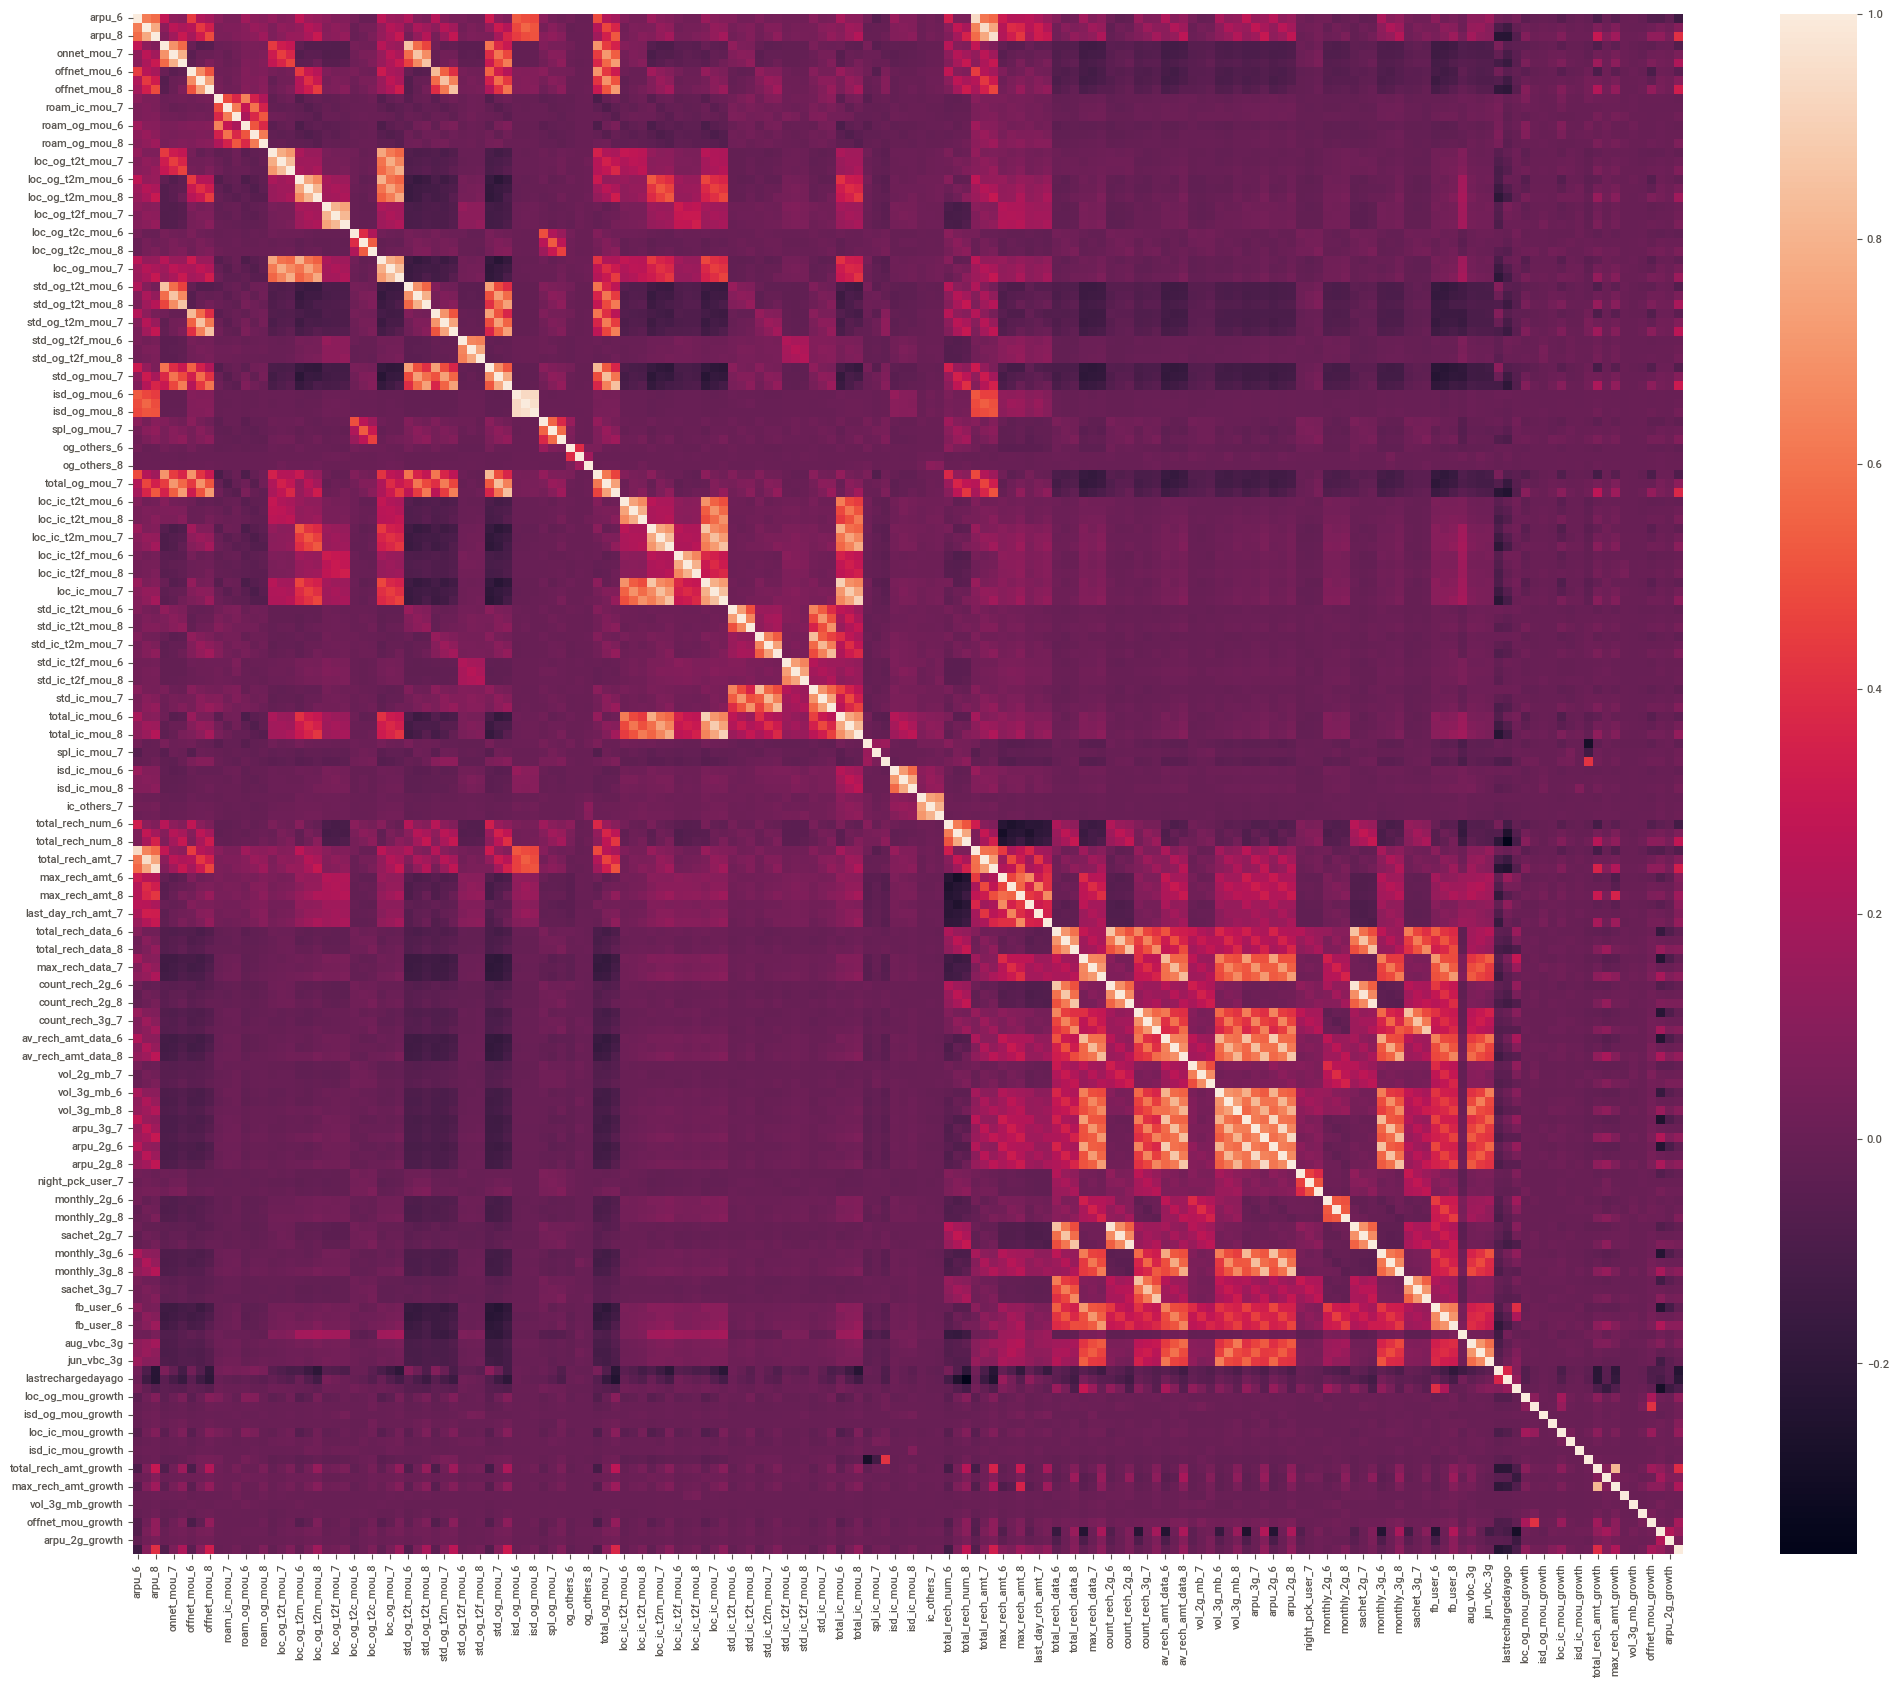

In [ ]:
plt.figure(figsize = (25, 20))

sns.heatmap(data_key_customers.corr())

plt.show()

In [ ]:
corr_matrix = data_key_customers.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
upper_triangle = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)))

highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]
print("List of highly correlated features from the above plot - \n\n", highly_correlated_features)
print("\n\nTotal features with high correlation - ", len(highly_correlated_features))

List of highly correlated features from the above plot - 

 ['loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'max_rech_amt_growth']


###Note:

On inspecting the data, we can see that are relationships betweens many columns. Few are  -


loc_og_mou_* = loc_og_t2t_mou_*
	     + loc_og_t2m_mou_*
	     + loc_og_t2f_mou_*
	     + loc_og_t2c_mou_*

std_og_mou_* = std_og_t2t_mou_*
	     + std_og_t2m_mou_*
	     + std_og_t2f_mou_*
	     + std_og_t2c_mou_*

total_og_mou_* = loc_og_mou_*
	      + std_og_mou_*
	      + isd_og_mou_*
	      + spl_og_mou_*
	      + X

loc_ic_mou_* = loc_ic_t2t_mou_*
	     + loc_ic_t2m_mou_*
	     + loc_ic_t2f_mou_*

std_ic_mou_* = std_ic_t2t_mou_*
	     + std_ic_t2m_mou_*
	     + std_ic_t2f_mou_*
	     + std_ic_t2o_mou_*

total_ic_mou_* = loc_ic_mou_*
	     + std_ic_mou_*
	     + spl_ic_mou_*
	     + isd_ic_mou_*
	     + Y

arpu_3g_* ,  arpu_2g_* and arpu are correlated.
total_rech_amt_*, max_rech_amt_*, last_day_rch_amt_* and av_rech_amt_data_* are correlated.


The highly correlated attributes can be dropped but we will be using PCA to reduce dimension and it will be handled as part of it.

We have few growth metrics derived and hence will drop few redudant columns in the next step.



In [ ]:
data = Preprocess(data,'DropRedundantColumns')
data_key_customers = Preprocess(data_key_customers,'DropRedundantColumns')

# 4. Create X, y and then Train test split


In [ ]:
data_modelling = data_key_customers.copy()
y = data_modelling.pop('churn_probability')
X = data_modelling

X.shape , y.shape

((18792, 72), (18792,))

Splitting train and test data to avoid any contamination of the test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state = 42, stratify = y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13154, 72), (5638, 72), (13154,), (5638,))

In [ ]:
X_train.head()

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,og_others_6,og_others_7,og_others_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,lastrechargedayago,lastdatarechargedayago,loc_og_mou_growth,std_og_mou_growth,isd_og_mou_growth,spl_og_mou_growth,loc_ic_mou_growth,std_ic_mou_growth,isd_ic_mou_growth,spl_ic_mou_growth,total_rech_amt_growth,av_rech_amt_data_growth,max_rech_amt_growth,vol_2g_mb_growth,vol_3g_mb_growth,onnet_mou_growth,offnet_mou_growth,arpu_3g_growth,arpu_2g_growth,arpu_growth
7569,249.54,0.0,0.0,172.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,20,14,30,44,42,3.0,2.0,1.0,25.0,25.0,23.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,3,2,1,0,0,0,0,0,0,1.0,1.0,0.0,887,0.0,55.58,0.0,2.0,17.0,1.5,0.9,1.0,53.1,1.6,0.3,1.0,1.0,0.8,0.4,0.7,0.0,0.0,1.2,1.1,1.0,0.0,0.8
8373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.83,0.0,12,15,21,50,10,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,364,0.0,0.0,0.0,2.0,0.0,1.4,0.6,1.0,1.6,2.4,0.8,1.0,0.0,1.6,1.0,1.1,1.0,1.0,0.5,1.8,1.0,1.0,1.5
4129,39.68,90.49,11.36,98.03,59.56,4.19,0.0,0.0,0.0,0.0,0.0,0.0,10,6,7,50,0,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1132,0.0,0.0,0.0,6.0,0.0,5.3,2.6,1.0,1.0,1.8,6.6,2.8,1.0,1.9,1.0,1.6,1.0,1.0,1.9,2.6,1.0,1.0,1.8
5684,0.0,0.0,0.0,0.0,0.0,0.0,1.31,0.0,0.0,0.0,0.0,0.0,9,6,9,120,120,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1495,0.0,0.0,0.0,1.0,0.0,1.2,0.9,1.0,0.1,1.0,25.7,0.0,1.0,1.2,1.0,1.2,1.0,1.0,0.9,1.5,1.0,1.0,1.1
14571,0.0,0.0,0.0,0.0,0.0,0.0,5.43,0.0,0.0,0.0,0.0,0.0,10,10,37,27,20,130,1.0,0.0,1.0,154.0,0.0,17.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1.0,0.0,1.0,307,0.0,0.0,0.0,1.0,22.0,14.4,1.0,14.6,8.2,2.6,1.0,8.3,1.0,8.0,0.2,1.8,0.0,1.0,35.5,13.9,1.0,0.9,7.9


Preparing data for model building. Apply Standard Scaler, SMOTE and PCA on the train/test split data

### SMOTE

Imbalance in the dataset can be addressed through many techniques and few of them include Resampling the data (Oversampling, Undersampling, Synthetic minority oversampling technique (SMOTE)) and Class Weight. We will try SMOTE and class weight for the 1st algorithm

### PCA

Principal Component Analysis (PCA) is a widely used technique in data analysis and machine learning for dimensionality reduction and feature extraction. It aims to transform a high-dimensional dataset into a lower-dimensional space while preserving the most important information in the data. We will retain 95% of the features in this implementation. This effectively reduces the dimensionality while still preserving most of the information in the dataset.

In [ ]:
numerical_features = [i for i in X.columns if not re.search('night|fb',i)]
categorical_features = [i for i in X.columns if re.search('night|fb',i)]

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply Standard Scaler
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.fit_transform(X_test[numerical_features])

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Handle imbalanced dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

# 5. Model Building

#Question : Which is the best Measure to assess model performance ?
#Answer : Depends

The choice of which measure to use depends on the problem at hand and the specific requirements. Some of the key measures are -

1.   Accuracy: Accuracy calculates the proportion of correctly predicted instances out of the total instances. It is suitable when the dataset is well-balanced, meaning the classes are represented equally. However, accuracy can be misleading when the dataset is imbalanced, where one class dominates the other. In such cases, accuracy alone may not provide an accurate picture of the model's performance.

2.   Precision: Precision measures the proportion of true positives (correctly predicted positive instances) out of the total predicted positive instances. Precision is useful when the focus is on minimizing false positives, i.e., reducing the number of instances falsely classified as positive. For example, in a medical diagnosis scenario, precision is crucial to avoid unnecessary treatments or interventions for healthy individuals.

3.   Recall (Sensitivity): Recall, also known as sensitivity or true positive rate, calculates the proportion of true positives out of the total actual positive instances. Recall is important when the emphasis is on minimizing false negatives, i.e., reducing instances that are incorrectly classified as negative when they should be positive. For example, In the analysis of a customer promotion activity for key customers, it is crucial to ensure that high-income generating customers are not overlooked.

4.   Specificity: Specificity calculates the proportion of true negatives (correctly predicted negative instances) out of the total actual negative instances. It complements recall and is particularly useful when the focus is on reducing false positives. For instance, in a fraud detection system, specificity helps in correctly identifying non-fraudulent transactions to minimize disruptions for legitimate customers.

5.   F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a single measure that balances both precision and recall, giving equal weight to both measures. The F1 score is useful when we want to consider both false positives and false negatives as important, seeking a balanced performance.

6.   Area Under the ROC Curve (AUC-ROC): The ROC curve represents the trade-off between the true positive rate (recall) and the false positive rate. AUC-ROC measures the area under this curve, providing an aggregate measure of a model's performance across various classification thresholds. AUC-ROC is commonly used when evaluating binary classifiers and is robust to imbalanced datasets. It provides a single metric that represents the overall performance of the model.

# Telecom customer churn prediction

In this scenario the company wants to identify customers who are likely to churn in order to offer retention incentives, the measure that is important is recall (sensitivity). The focus is on minimizing false negatives, which means correctly identifying as many potential churners as possible. By maximizing recall, the company can ensure that they don't miss out on customers who are likely to churn and can take appropriate actions to retain them.

In this implementation, we have focussed on the accuracy since the problem statement mentioned that "Accuracy" will be primary evaluation metrics but will recommend to focus on "recall" in the realtime implementation

### **Logistics Regression**

#### 1. Logistic Regression with PCA and Class Weight to handle imbalance data

In [ ]:
# class imbalance
# Idnentiying Weights
w0 = y_train.value_counts().sum()/y_train.value_counts()[0]*2
w1 = y_train.value_counts().sum()/y_train.value_counts()[1]*2
w0,w1

(2.2495083368961093, 18.031528444139823)

In [ ]:
# Create a logistic regression model
lr = LogisticRegression(class_weight={0:w0, 1: w1})

# Define the hyperparameters for tuning
parameters = {'C': [100, 10, 1.0, 0.1, 0.01],
              'penalty': ['l2']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Perform hyperparameter tuning using grid search
grid_search = GridSearchCV(estimator=lr, param_grid=parameters, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

grid_search.fit(X_train_pca, y_train)

# Get the best model
lr_model = grid_search.best_estimator_

# print best hyperparameters
print("Best Score during testing : \n")
print("Best Score: ", grid_search.best_score_)
print("Best hyperparameters: ", grid_search.best_params_)
# Make predictions on the test set
y_pred = lr_model.predict(X_test_pca)

# Display accuracy, recall, f1 score and confusion matrix
print("Best Score during testing : \n")

# Display accuracy, recall, f1 score and confusion matrix
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best Score during testing : 

Best Score:  0.8352608819597734
Best hyperparameters:  {'C': 0.01, 'penalty': 'l2'}
Best Score during testing : 

ROCAUC score: 0.499906483143826
Accuracy score: 0.8852429939694927
Recall: 0.0048
F1 score: 0.009188361408882082

Confusion Matrix:
[[4988   25]
 [ 622    3]]


#### 2. Logistic Regression with PCA and SMOTE to handle imbalance data

In [ ]:
# Create a logistic regression model
lr = LogisticRegression()

# Define the hyperparameters for tuning
parameters = {'C': [100, 10, 1.0, 0.1, 0.01],
              'penalty': ['l2']}

# RepeatedStratifiedKFold repeats this process multiple times, allowing for a more reliable evaluation of the model's performance
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Perform hyperparameter tuning using grid search
grid_search = GridSearchCV(estimator=lr, param_grid=parameters, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
lr_model = grid_search.best_estimator_

# print best hyperparameters
print("Best Score during testing : \n")
print("Best Score: ", grid_search.best_score_)
print("Best hyperparameters: ", grid_search.best_params_)

# Make predictions on the test set
y_pred = lr_model.predict(X_test_pca)

# Display accuracy, recall, f1 score and confusion matrix
print("Best Score during testing : \n")
# Display accuracy, recall, f1 score and confusion matrix
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best Score during testing : 

Best Score:  0.8439931594698589
Best hyperparameters:  {'C': 100, 'penalty': 'l2'}
Best Score during testing : 

ROCAUC score: 0.8099051266706564
Accuracy score: 0.8350478893224548
Recall: 0.7776
F1 score: 0.5110410094637224

Confusion Matrix:
[[4222  791]
 [ 139  486]]


#### 3. Logistic Regression with PCA and SMOTE using different hyperparameter

In [ ]:
# Create a logistic regression model
lr = LogisticRegression()

# Define the hyperparameters for tuning
parameters = {'C': [100, 10, 1.0, 0.1, 0.01],
              'solver': ['liblinear','sag','newton-cg','lbfgs','saga'],
              'penalty': ['l1','l2']}

# RepeatedStratifiedKFold repeats this process multiple times, allowing for a more reliable evaluation of the model's performance
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Perform hyperparameter tuning using grid search
grid_search = GridSearchCV(estimator=lr, param_grid=parameters, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
lr_model = grid_search.best_estimator_

# print best hyperparameters
print("Best Score during testing : \n")
print("Best Score: ", grid_search.best_score_)
print("Best hyperparameters: ", grid_search.best_params_)

# Make predictions on the test set
y_pred = lr_model.predict(X_test_pca)

# Display accuracy, recall, f1 score and confusion matrix
print("Best Score during testing : \n")
# Display accuracy, recall, f1 score and confusion matrix
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best Score during testing : 

Best Score:  0.8440786660966225
Best hyperparameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best Score during testing : 

ROCAUC score: 0.8122033113903852
Accuracy score: 0.8366442000709472
Recall: 0.7808
F1 score: 0.514496573537164

Confusion Matrix:
[[4229  784]
 [ 137  488]]


Note: After trying other hyper parameters, we can conclude this is the best performance we could get from Logistics Regression

###**Random Forest**

Random Forest with SMOTE approach with a range of hyperparameters

In [ ]:
# Random Forest Classifier
rfc = RandomForestClassifier()

# Define the hyperparameter grid for tuning
# Trying sqrt and log2 of total number of features for max features
params = {
      "max_features": [10, 15, 20],
      "n_estimators": [300, 500],
      "max_depth": [10, 15]
}

# The folds are made by preserving the percentage of samples for each class.
cv = StratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid_search =  GridSearchCV(estimator = rfc,
                    param_grid = params,
                    cv = cv,
                    verbose= 5,
                    scoring ="accuracy")

grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator from the grid search
rfc_model = grid_search.best_estimator_

# print best hyperparameters
print("Best Score during testing : \n")
print("Best Score: ", grid_search.best_score_)
print("Best hyperparameters: ", grid_search.best_params_)

# Make predictions on the test set
y_pred = rfc_model.predict(X_test_pca)

# Display accuracy, recall, f1 score and confusion matrix
print("Best Score during testing : \n")
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# check area under curve
y_pred_prob = rfc_model.predict_proba(X_test_pca)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))


NameError: ignored

### 3. XGBoost

XGBoost  Forest with SMOTE approach with a range of hyperparameters

Best Score during training : 

Best Score:  0.9569046601111586
Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 700}
Best Score during testing : 

ROCAUC score: 0.7832726112108518
Accuracy score: 0.908478183753104
Recall: 0.6224
F1 score: 0.6012364760432766

Confusion Matrix:
[[4733  280]
 [ 236  389]]
AUC:    	 0.9


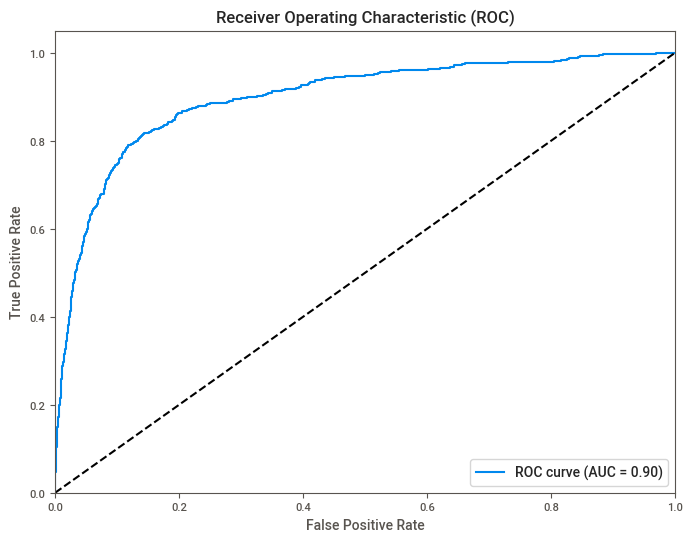

In [ ]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [10, 15],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [300, 500]
}

# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

# The StratifiedKFold are made by preserving the percentage of samples for each class.
cv = StratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=cv)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and model
xgb_params = grid_search.best_params_
xgb_model = grid_search.best_estimator_

# print best hyperparameters
print("Best Score during training : \n")
print("Best Score: ", grid_search.best_score_)
print("Best hyperparameters: ", grid_search.best_params_)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test_pca)

# Display accuracy, recall, f1 score and confusion matrix
print("Best Score during testing : \n")
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# check area under curve
y_pred_prob = xgb_model.predict_proba(X_test_pca)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# 6. Identify Key Features

### Random Forest Model to identify key features

In [ ]:

# Create an instance of the Random Forest Classifier
rf_model = RandomForestClassifier(max_features=15, max_depth=10, n_estimators=100, random_state=42, n_jobs = -1)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a dataframe of feature importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
top_features = feature_importance_df.nlargest(5, 'Importance')

print('Top 5 Features:')
print(top_features)

# Display accuracy, recall, f1 score and confusion matrix
print("Best Score during testing : \n")
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Top 5 Features:
                  Feature          Importance
58      loc_ic_mou_growth 0.18373861637540204
71            arpu_growth 0.10015931218365656
54      loc_og_mou_growth 0.07181490004669802
62  total_rech_amt_growth 0.07141129526225079
64    max_rech_amt_growth 0.05172413251225048
Best Score during testing : 

ROCAUC score: 0.7473287851585877
Accuracy score: 0.9267470734302944
Recall: 0.5168
F1 score: 0.6100094428706327

Confusion Matrix:
[[4902  111]
 [ 302  323]]


###Note:

Key factors which can help identify churn are -

1. loc_ic_mou_growth
2. total_ic_mou_growth
3. arpu_growth
4. total_rech_amt_growth
5. max_rech_amt_growth

Incoming calls - local and total, Average Revenue Per Unit, Average Revenue per unit and Recharge amount percentage growth declines during the action phase can be used to predict churn.

#7. Preparing Model for Final Training and Prediction

In [ ]:
unseen = pd.read_csv("test.csv")
unseen_processed = unseen.copy()
sample = pd.read_csv("sample.csv")

In [ ]:
unseen_processed = Preprocess(unseen_processed,'DropUniqueColumns')
unseen_processed = Preprocess(unseen_processed,'Drop0VariationColumns')
unseen_processed = Preprocess(unseen_processed,'ConverttoDate')
unseen_processed = Preprocess(unseen_processed,'DeriveLastRechargeDay')
unseen_processed = Preprocess(unseen_processed,'Fill0inFloatColumns')
unseen_processed = Preprocess(unseen_processed,'DeriveAdditionalFeatures')
unseen_processed = Preprocess(unseen_processed,'HandleOutliers')
unseen_processed = Preprocess(unseen_processed,'DropRedundantColumns')


In [ ]:
#Get training and test data
y_train_final = data_key_customers.pop('churn_probability')
X_train_final = data_key_customers.copy()
X_test_final = unseen_processed.copy()

# Apply Standard Scaler
scaler_final = StandardScaler()
X_train_final[numerical_features] = scaler.fit_transform(X_train_final[numerical_features])
X_test_final[numerical_features] = scaler.fit_transform(X_test_final[numerical_features])

# Apply PCA to reduce dimensionality
pca_final = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca_final = pca_final.fit_transform(X_train_final)
X_test_pca_final = pca_final.transform(X_test_final)

# Handle imbalanced dataset using SMOTE
smote_final = SMOTE(random_state=42)
X_train_resampled_final, y_train_resampled_final = smote_final.fit_resample(X_train_pca_final, y_train_final)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [10],
    'learning_rate': [0.1],
    'n_estimators': [500]
}

# Create the XGBoost classifier
xgb_model_final = xgb.XGBClassifier(objective='binary:logistic')

# Perform grid search cross-validation
grid_search_final = GridSearchCV(estimator=xgb_model_final, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search_final.fit(X_train_resampled_final, y_train_resampled_final)

# Get the best model
xgb_model_final = grid_search_final.best_estimator_

# print best hyperparameters
print("Best Score during training : \n")
print("Best Score: ", grid_search_final.best_score_)

# Make predictions on the test set
unseen['churn_probability'] = xgb_model_final.predict(X_test_pca_final)

Best Score during training : 

Best Score:  0.9563683651893078


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output = unseen[['id','churn_probability']]
output.to_csv('submission.csv',index=False)

# 8. Business Recommendations

1. As per study, network quality is a key criteria customer looks for and the company can improve their effort towards improving their network quality

https://www.ijert.org/research/a-survey-on-factors-impacting-churn-in-telecommunication-using-datamininig-techniques-IJERTV3IS031583.pdf

2. People who are relatiely new to the company ( aon -1-3) churn more than others so the telecom company can look to introduce some offers around data or IC/OG calls

3. Company could look to provide some package offers - local calls/data/facebook service. We could see if we can information on the customer profile - age/occupation and offer packages accordingly i.e Facebook pack for college student.